In [301]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import linear_model

In [302]:
df1 = pd.read_csv("House_Data.csv")
df1 = df1.drop_duplicates('full_address', keep='last')
df2 = df1.drop(['status','sold_date'], axis='columns')
df3 = df2.dropna()

In [303]:
df3.drop(df3.index[df3['state'] == ('Puerto Rico')], inplace=True)
df3.drop(df3.index[df3['state'] == ('Virgin Islands')], inplace=True)
df3.drop(df3.index[df3['state'] == ('Wyoming')], inplace=True)
df3.drop(df3.index[df3['state'] == ('Maine')], inplace=True)
df3.drop(df3.index[df3['state'] == ('West Virginia')], inplace=True)
df3.drop(df3.index[df3['state'] == ('New Hampshire')], inplace=True)
df3.drop(df3.index[df3['state'] == ('Vermont')], inplace=True)
df3.head()

C:\Users\elian\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size
30307,279900.0,3.0,2.0,0.35,"11 Schenone Ct, Plainville, CT, 06062",11 Schenone Ct,Plainville,Connecticut,6062.0,1004.0
46573,185000.0,7.0,2.0,0.11,"193-195 White St, Springfield, MA, 01108",193-195 White St,Springfield,Massachusetts,1108.0,3319.0
48824,349900.0,4.0,2.0,1.03,"193 Kibbe Rd, East Longmeadow, MA, 01028",193 Kibbe Rd,East Longmeadow,Massachusetts,1028.0,1638.0
54141,219000.0,3.0,1.0,0.29,"482 Brewer St, East Hartford, CT, 06118",482 Brewer St,East Hartford,Connecticut,6118.0,960.0
54530,40000.0,2.0,1.0,0.20,"423 Morey Park Hill Rd, Nassau, NY, 12123",423 Morey Park Hill Rd,Nassau,New York,12123.0,690.0


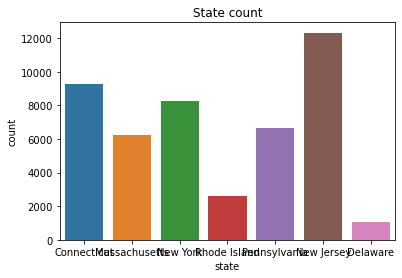

In [304]:
plt.title('State count')
sns.countplot(x=df3['state']) # count the values of each borough
plt.rcParams["figure.figsize"] = (10,10)

plt.show()

In [305]:
df4 = df3.copy()
df4['Price_per_sqft'] = df4['price']/df4['house_size']

In [306]:
# eliminates data that has wrong information of number of bathroom based on the side of the house
df5 = df4[~((df4.house_size/df4.bath<250) & (df4['bath']!=1))]
df5.shape

(46318, 11)

In [307]:
zip_code_stats = df5['zip_code'].value_counts(ascending=False)
zip_code_stats

19134.0    255
19146.0    232
19145.0    227
19148.0    212
19124.0    201
          ... 
1344.0       1
1378.0       1
1355.0       1
12919.0      1
10578.0      1
Name: zip_code, Length: 2041, dtype: int64

In [308]:
zip_code_stats_7 = zip_code_stats[zip_code_stats<=6]
zip_code_stats_7

11563.0    6
11693.0    6
11501.0    6
2671.0     6
2452.0     6
          ..
1344.0     1
1378.0     1
1355.0     1
12919.0    1
10578.0    1
Name: zip_code, Length: 616, dtype: int64

In [309]:
df5['zip_code'] = df5['zip_code'].apply(lambda x: 'other' if x in zip_code_stats_7 else x)
len(df5['zip_code'].unique())

C:\Users\elian\AppData\Local\Temp/ipykernel_8076/482896947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['zip_code'] = df5['zip_code'].apply(lambda x: 'other' if x in zip_code_stats_7 else x)


1426

In [310]:
# removing outliers (data that skewed our overall result)
def remove_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('zip_code'):
        m = np.mean(subdf.Price_per_sqft)
        st = np.std(subdf.Price_per_sqft)
        reduced_df = subdf[(subdf.Price_per_sqft>(m-st)) & (subdf.Price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df], ignore_index=True)
    return df_out

df6 = remove_outliers(df5)

In [311]:
df7 = df6.copy()
df7 = df6.drop_duplicates(subset='full_address', keep='last')

### This portion of the project was made in case that I ever want to approximate the house price by their latitude and longitude

In [312]:
import re

patron = "Apt [^',']+|Unit [^',']+|Unit-[^',']+"
patron1 = "Units 1,2,3 and 4,"
patron2 = "Units [^',']+"
patron3 = "\d{1}-\d{1}|\d{2}-\d{2}|\d{3}-\d{3}|\d{1}-\d{2}|\d{1}-\d{3}|\d{2}-\d{1}|\d{3}-\d{1}"

df7['full_address'] = df7['full_address'].str.replace(patron,'', regex=True)
df7['full_address'] = df7['full_address'].str.replace(patron1,'', regex=True)
df7['full_address'] = df7['full_address'].str.replace(patron2,'', regex=True)
df7['full_address'] = df7['full_address'].str.replace(patron3,'', regex=True)

In [313]:
df7 = df7[df7['full_address'].str.contains('/')==False]
df7 = df7[df7['full_address'].str.contains('-')==False]

In [314]:
# full_lat = []
# full_long = []

# for locality in df7['full_address']:
#     location = geolocator.geocode(locality)
#     if location is None:
#         full_lat.append('-1')
#         full_long.append('-1')
#     else:
#         full_lat.append(location.latitude)
#         full_long.append(location.longitude)

### The following part of the project uses zipcode for price prediction

In [315]:
df7.shape

(34390, 11)

In [316]:
prueba = df7[df7['state']=='New York']
prueba = prueba[prueba['price']<5000000]
borought = ['Staten Island', 'Brooklyn', 'New York City', 'Yonkers', 'Bronx']

x1 = prueba[prueba['city'].isin(borought)]

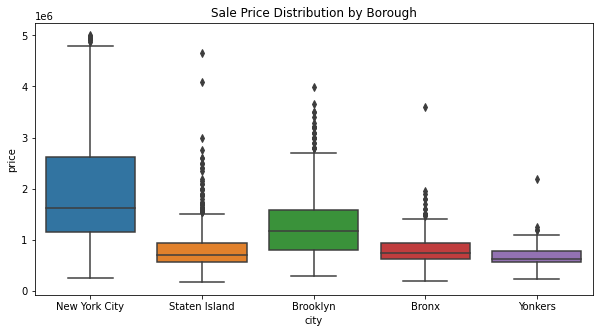

In [317]:
# Sales prices by borough
plt.figure(figsize=(10,5))
sns.boxplot(x='city', y='price', data=x1)
plt.title('Sale Price Distribution by Borough')
plt.show()

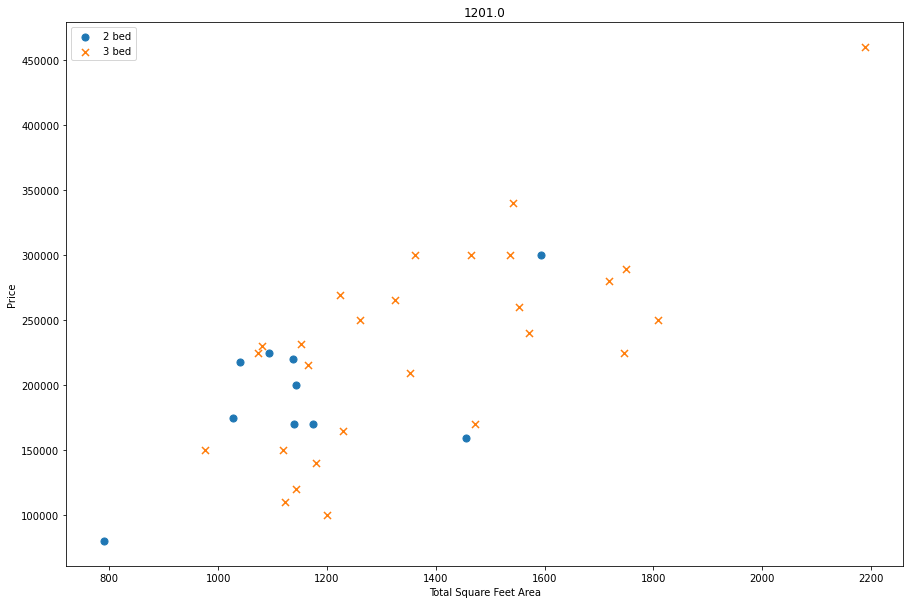

In [318]:
# this is to figure out if there are a relationship between number of bed, house size and price
def plot_scatter_chart(df, loc):
    bed2 = df[(df.zip_code==loc) & (df.bed==2)]
    bed3 = df[(df.zip_code==loc) & (df.bed==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bed2.house_size,bed2.price,label='2 bed',s=50)
    plt.scatter(bed3.house_size,bed3.price,marker='x',label='3 bed',s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price")
    plt.title(loc)
    plt.legend()

plot_scatter_chart(df7, 1201.0)

In [319]:
df7.shape

(34390, 11)

### Removing outliers

In [320]:
# remove properties that has n number of bedrooms and their price per sqft is less than
# properties with n-1 number of bedrooms with the same house_size
def remove_bed_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('zip_code'):
        bed_stats = {}
        for bed, bed_df in location_df.groupby('bed'): # this group apartments based on thier number of bedrooms
            bed_stats[bed] = {
                'mean': np.mean(bed_df.Price_per_sqft),
                'std': np.std(bed_df.Price_per_sqft),
                'count': bed_df.shape[0]
            }
        for bed, bed_df in location_df.groupby('bed'):
            stats = bed_stats.get(bed-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bed_df[bed_df.Price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bed_outliers(df7)
# df8 = df7.copy()
df8.shape

(25416, 11)

Text(0, 0.5, 'Count')

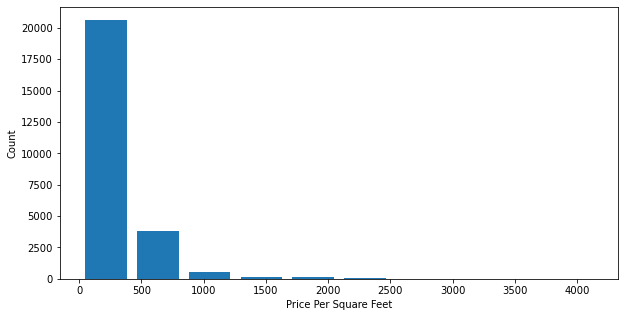

In [321]:
matplotlib.rcParams["figure.figsize"] = (10,5)
plt.hist(df8.Price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

In [322]:
df8.bath.unique()

array([ 3.,  2.,  1.,  4.,  5.,  6., 16.,  8.,  7., 15.,  9., 10., 12.,
       11., 13., 51., 22., 20., 17., 14., 24., 19., 43., 36.])

In [323]:
df8[df8.bath>df8.bed] # is weird that a house has more bathrooms than bedroom. 
# it looks like there are some errors in this data

,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,Price_per_sqft
22,849900.0,4.0,5.0,3.97,"1246 South St, Barre, MA, 01005",1246 South St,Barre,Massachusetts,1005.0,5023.0,169.201672
101,1295000.0,4.0,5.0,7.81,"25 Sylvia Hts, Hadley, MA, 01035",25 Sylvia Hts,Hadley,Massachusetts,1035.0,7000.0,185.000000
184,539000.0,3.0,4.0,1.11,"57 Jessie Ln, Westfield, MA, 01085",57 Jessie Ln,Westfield,Massachusetts,1085.0,3577.0,150.684932
198,1249000.0,3.0,4.0,1.40,"12 Falcon Hts, Wilbraham, MA, 01095",12 Falcon Hts,Wilbraham,Massachusetts,1095.0,4936.0,253.038898
225,394900.0,3.0,4.0,0.44,"6 Blueberry Hill Rd, Longmeadow, MA, 01106",6 Blueberry Hill Rd,Longmeadow,Massachusetts,1106.0,2025.0,195.012346
...,...,...,...,...,...,...,...,...,...,...,...
34423,1250000.0,3.0,4.0,0.28,"11 Arlena Ter, Ramsey, NJ, 07446",11 Arlena Ter,Ramsey,New Jersey,other,4201.0,297.548203
34437,1630000.0,5.0,6.0,0.97,"55 Timberlane Rd, Upper Saddle River, NJ, 07458",55 Timberlane Rd,Upper Saddle River,New Jersey,other,5500.0,296.363636
34446,1100000.0,3.0,4.0,38.10,"2990 Stony St, Mohegan Lake, NY, 10547",2990 Stony St,Mohegan Lake,New York,other,2614.0,420.811018
34484,275000.0,1.0,2.0,0.24,"274 Westchester Ave, Buchanan, NY, 10511",274 Westchester Ave,Buchanan,New York,other,720.0,381.944444


In [324]:
df9 = df8[df8.bath<=df8.bed]
df9.shape

(23279, 11)

In [325]:
df9.head()

,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,Price_per_sqft
0,525000.0,3.0,3.0,0.45,"955 River Rd, Agawam, MA, 01001",955 River Rd,Agawam,Massachusetts,1001.0,2314.0,226.879862
1,289900.0,3.0,2.0,0.36,"82 Harvey Johnson Dr, Agawam, MA, 01001",82 Harvey Johnson Dr,Agawam,Massachusetts,1001.0,1276.0,227.194357
2,275000.0,4.0,2.0,0.11,"King Ave, Agawam, MA, 01001",6-8 King Ave,Agawam,Massachusetts,1001.0,1732.0,158.775982
3,335000.0,6.0,2.0,0.24,"Ley St, Agawam, MA, 01001",41-43 Ley St,Agawam,Massachusetts,1001.0,1800.0,186.111111
4,239900.0,3.0,1.0,0.46,"270 South St, Agawam, MA, 01001",270 South St,Agawam,Massachusetts,1001.0,1196.0,200.585284


In [326]:
df10 = df9.drop(['acre_lot','full_address','street','state','Price_per_sqft', 'city'],axis='columns')
df10.head(3)

,price,bed,bath,zip_code,house_size
0,525000.0,3.0,3.0,1001.0,2314.0
1,289900.0,3.0,2.0,1001.0,1276.0
2,275000.0,4.0,2.0,1001.0,1732.0


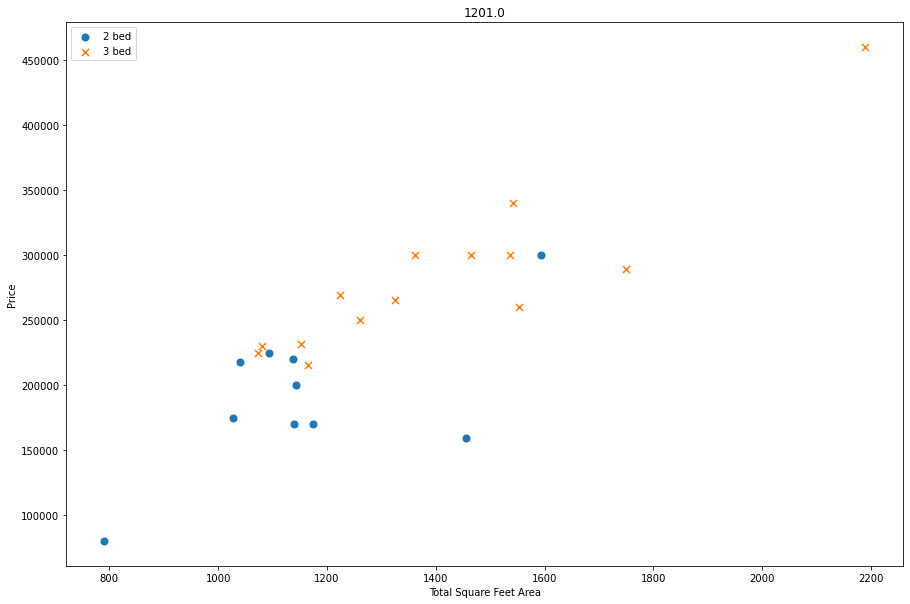

In [327]:
plot_scatter_chart(df10, 1201.0)

In [343]:
dummies = pd.get_dummies(df10['zip_code'])
dummies.head()

,1001.0,1002.0,1005.0,1007.0,1013.0,1020.0,1027.0,1028.0,1030.0,1033.0,...,19803.0,19804.0,19805.0,19806.0,19807.0,19808.0,19809.0,19810.0,19977.0,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [345]:
df10.head()

,price,bed,bath,zip_code,house_size
0,525000.0,3.0,3.0,1001.0,2314.0
1,289900.0,3.0,2.0,1001.0,1276.0
2,275000.0,4.0,2.0,1001.0,1732.0
3,335000.0,6.0,2.0,1001.0,1800.0
4,239900.0,3.0,1.0,1001.0,1196.0


In [346]:
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head()

,price,bed,bath,zip_code,house_size,1001.0,1002.0,1005.0,1007.0,1013.0,...,19802.0,19803.0,19804.0,19805.0,19806.0,19807.0,19808.0,19809.0,19810.0,19977.0
0,525000.0,3.0,3.0,1001.0,2314.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,289900.0,3.0,2.0,1001.0,1276.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,275000.0,4.0,2.0,1001.0,1732.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,335000.0,6.0,2.0,1001.0,1800.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,239900.0,3.0,1.0,1001.0,1196.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [347]:
df12 = df11.drop('zip_code', axis='columns')
df12.head()

,price,bed,bath,house_size,1001.0,1002.0,1005.0,1007.0,1013.0,1020.0,...,19802.0,19803.0,19804.0,19805.0,19806.0,19807.0,19808.0,19809.0,19810.0,19977.0
0,525000.0,3.0,3.0,2314.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,289900.0,3.0,2.0,1276.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,275000.0,4.0,2.0,1732.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,335000.0,6.0,2.0,1800.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,239900.0,3.0,1.0,1196.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [348]:
# model training
X = df12.drop('price', axis='columns')
X.head()

,bed,bath,house_size,1001.0,1002.0,1005.0,1007.0,1013.0,1020.0,1027.0,...,19802.0,19803.0,19804.0,19805.0,19806.0,19807.0,19808.0,19809.0,19810.0,19977.0
0,3.0,3.0,2314.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.0,2.0,1276.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.0,2.0,1732.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6.0,2.0,1800.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1.0,1196.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [349]:
X.shape

(23279, 1428)

In [334]:
y = df12['price']
y.head()

0    525000.0
1    289900.0
2    275000.0
3    335000.0
4    239900.0
Name: price, dtype: float64

In [350]:
y.shape

(23279,)

In [351]:
from sklearn.model_selection import train_test_split
# 20% of my data will be used for testing my model and the rest will be used to build my model
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10) 

In [352]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train) # creates the model for price prediction
lr_clf.score(X_test,y_test) # test the model 

0.7297320349337666

In [353]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) # shuffle the test data

cross_val_score(LinearRegression(), X, y, cv=cv)

array([-3.87086801e+14,  6.69506079e-01,  5.70608729e-01,  7.23870066e-01,
        6.36335820e-01])

### Testing the model 

In [355]:
X.columns

Index([       'bed',       'bath', 'house_size',       1001.0,       1002.0,
             1005.0,       1007.0,       1013.0,       1020.0,       1027.0,
       ...
            19802.0,      19803.0,      19804.0,      19805.0,      19806.0,
            19807.0,      19808.0,      19809.0,      19810.0,      19977.0],
      dtype='object', length=1428)

In [356]:
loc_index = np.where(X.columns==1007.0)[0][0]
loc_index

6

In [377]:
def predict_price(zip_code,size,bed,bath):    
    loc_index = np.where(X.columns==zip_code)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = bed
    x[1] = bath
    x[2] = size
    if loc_index >= 0:
        x[loc_index] = 1

    return abs(lr_clf.predict([x])[0])

### Observations

In [378]:
predict_price(1001.0,1000, 1, 1)

77811.76631152644

In [379]:
predict_price(1001.0,2000, 2, 2)

414106.3363966884

In [380]:
predict_price(1013.0,1000, 2, 2)

50600.32640548964

In [381]:
predict_price(19802.0,1000, 2, 2)

102851.75876017782

In [383]:
predict_price(19802.0,1000, 1, 1)

14955.703080016043

### Export Model

In [384]:
import pickle
with open('house_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

### Export Columns

In [386]:
import json
columns = {
    'data_columns' : [col for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))